# Regular Genomics Project **RNA Localisation**


---

**Problem definition**:

TODO


### **1.** Data Preparation

Firstly, we import several necessary packages and load in our data:

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Initializing test/train split


colab = False  #### Set colab flag ####

if colab:
    np.random.seed(3)
    url = 'https://www.dropbox.com/s/hv4uau8q4wwg00k/final_data.csv?dl=1'
    data_org = pd.read_csv(url)
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index)
else:
    np.random.seed(3)
    data_org = pd.read_csv('~/Downloads/final_data.csv')
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index) # TODO: note: we also have to preprocess the test set similary
    # TODO: colab

data_org

,ERM,KDEL,LMA,MITO,NES,NIK,NLS,NUCP,OMM,gene_id,gene_biotype,seq,struct,m6A_5UTR,m6A_CDS,m6A_3UTR
0,57.045409,35.456782,22.008215,12.355106,22.789983,24.241731,16.970436,29.348389,54.916891,ENSG00000000003,protein_coding,ACCTTGTATTAGGTATTTATTTCCACAAAAGTTTGATGCTTACAAC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,1
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.914814,0.244517,ENSG00000000005,protein_coding,TGTGCACAGAAGTTATATACATATATGGGTATATCTATGTAACAAA...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
2,17.449430,34.151539,29.338431,22.237585,24.682767,43.612551,38.683963,35.678476,25.348560,ENSG00000000419,protein_coding,TACTTTATGCAAAAAAAAATATACATTTATTTATAGGTCTCAATAC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
3,3.830180,2.576734,5.737850,0.761343,2.786808,2.784356,3.382682,2.463676,2.819269,ENSG00000000457,protein_coding,TGACTTTCAAACCATTTTAATATTTCAAATATTCCAGAACAATCCC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,9,5
4,13.132915,8.782925,10.061390,3.012459,8.821250,6.721117,10.827253,8.005113,6.849962,ENSG00000000460,protein_coding,AACCCGCTCGGGTCCCCTTCCACACTGTGGAAGCTTTGTTCTTTCG...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13805,0.000000,0.000000,0.506809,0.075893,0.050764,0.000000,0.056586,0.000000,0.000000,ENSG00000281883,protein_coding,GGGAAGAAAGGAGCCTGACTCTTATGATGGAATAACCACAAATCAG...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,2,1
13806,0.105452,0.087130,0.171187,0.016101,0.079057,0.669947,0.171672,0.000000,0.254546,ENSG00000282034,protein_coding,GTGTCGGACGGCATGACAGGCAGCAATCCTGTGTCCCCTGCCTCAT...,"[0.37599998712539673, 0.0, 0.07500000298023224...",0,66,4
13807,0.037093,0.444844,0.425368,0.254467,0.323794,1.803249,1.435483,0.249590,0.483645,ENSG00000282827,protein_coding,ATGGCGGGGACCTCCGCGCCAGGCAGCAAGAGGCGGAGCGAGCCCC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
13808,0.000000,0.519421,2.119115,0.360450,0.887939,0.345021,1.274465,0.741954,0.460649,ENSG00000282936,protein_coding,CTACTGGAACGCCCCCCTCAATCTAGCCTCCCCCACATAACTCTCT...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,2


### **2** |  Initializations

We use as baseline model the [RNATracker](https://github.com/HarveyYan/RNATracker/blob/master/Models/cnn_bilstm_attention.py) model and a CNN model.


In [3]:
from notes.utils import read_model_file

max_seq_len = train_data['seq'].apply(lambda x: len(x)).max()
params_dict = read_model_file('model_architectures/CNN_architecture1.yaml', max_seq_len)
param_dataLoader_valid = params_dict['param_dataLoader_valid']
param_dataLoader_train = params_dict['param_dataLoader_train']
params_model = params_dict['params_model']
params_train = params_dict['params_train']

In [4]:
# training, only need for the model initialization to change in general
from models import func_CNN as CNN

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)

model = CNN(architecure='cpfe',
            input_size=(max_seq_len, 4),
            params_model=params_model)     

model.summary()

2023-06-25 11:26:02.898049: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34526, 4)]        0         
                                                                 
 conv1d (Conv1D)             (None, 34518, 64)         2368      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 9)                 585       
                                                                 
Total params: 2,953
Trainable params: 2,953
Non-trainable params: 0
___________________________________________________________

In [5]:
#model.fit(train_data, params_dataLoader=param_dataLoader_train, params_train=params_train)

In [6]:
history = model.fit_and_evaluate(train_data=train_data, eval_data=valid_data, 
                                 params_train_dataLoader=param_dataLoader_train, 
                                 params_eval_dataLoader=param_dataLoader_valid, 
                                 params_train=params_train)


Epoch 1/10


2023-06-25 11:26:09.879927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


311/311 [==============================] - ETA: 0s - loss: 2.1749 - accuracy: 0.1700

2023-06-25 11:27:24.607635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


311/311 [==============================] - 93s 284ms/step - loss: 2.1749 - accuracy: 0.1700 - val_loss: 2.1705 - val_accuracy: 0.1581
Epoch 2/10
311/311 [==============================] - 90s 274ms/step - loss: 2.1686 - accuracy: 0.1833 - val_loss: 2.1706 - val_accuracy: 0.1790
Epoch 3/10
311/311 [==============================] - 91s 278ms/step - loss: 2.1664 - accuracy: 0.1914 - val_loss: 2.1695 - val_accuracy: 0.1689
Epoch 4/10
311/311 [==============================] - 89s 272ms/step - loss: 2.1648 - accuracy: 0.2015 - val_loss: 2.1679 - val_accuracy: 0.1959
Epoch 5/10
311/311 [==============================] - 90s 276ms/step - loss: 2.1641 - accuracy: 0.2093 - val_loss: 2.1686 - val_accuracy: 0.1854
Epoch 6/10
311/311 [==============================] - 90s 275ms/step - loss: 2.1631 - accuracy: 0.2093 - val_loss: 2.1677 - val_accuracy: 0.1919
Epoch 7/10
311/311 [==============================] - 90s 276ms/step - loss: 2.1625 - accuracy: 0.2101 - val_loss: 2.1682 - val_accuracy: 0.1

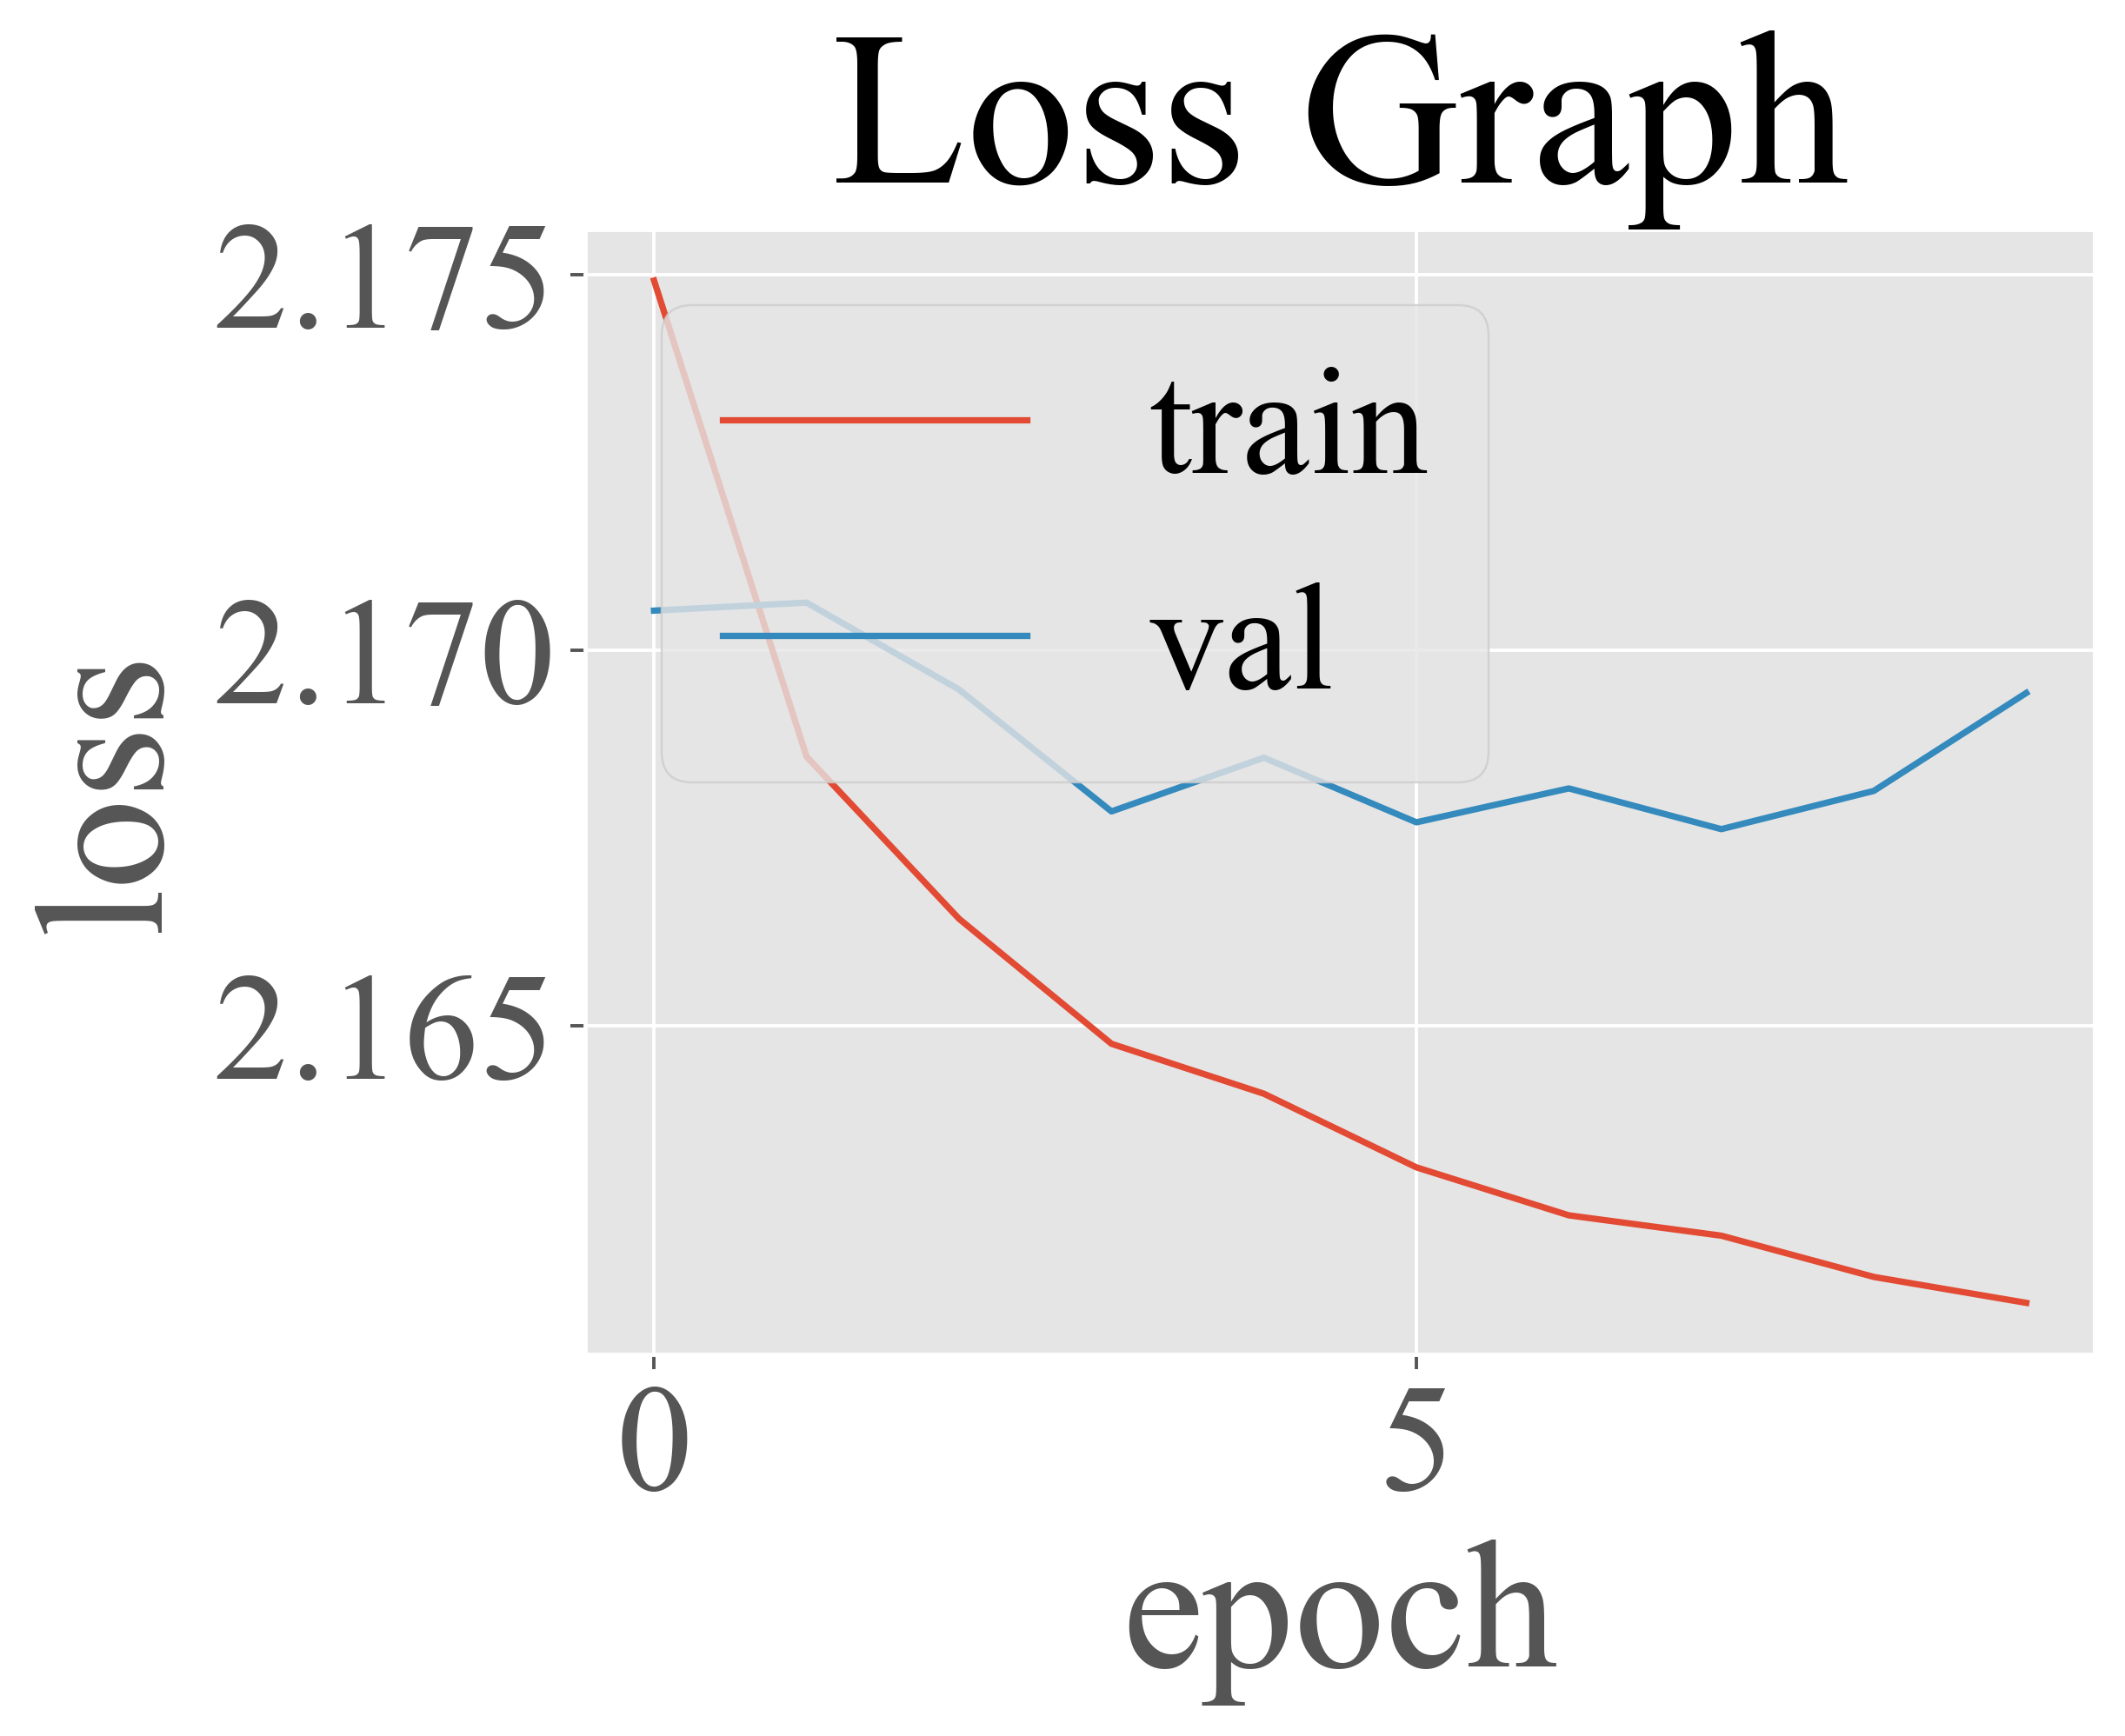

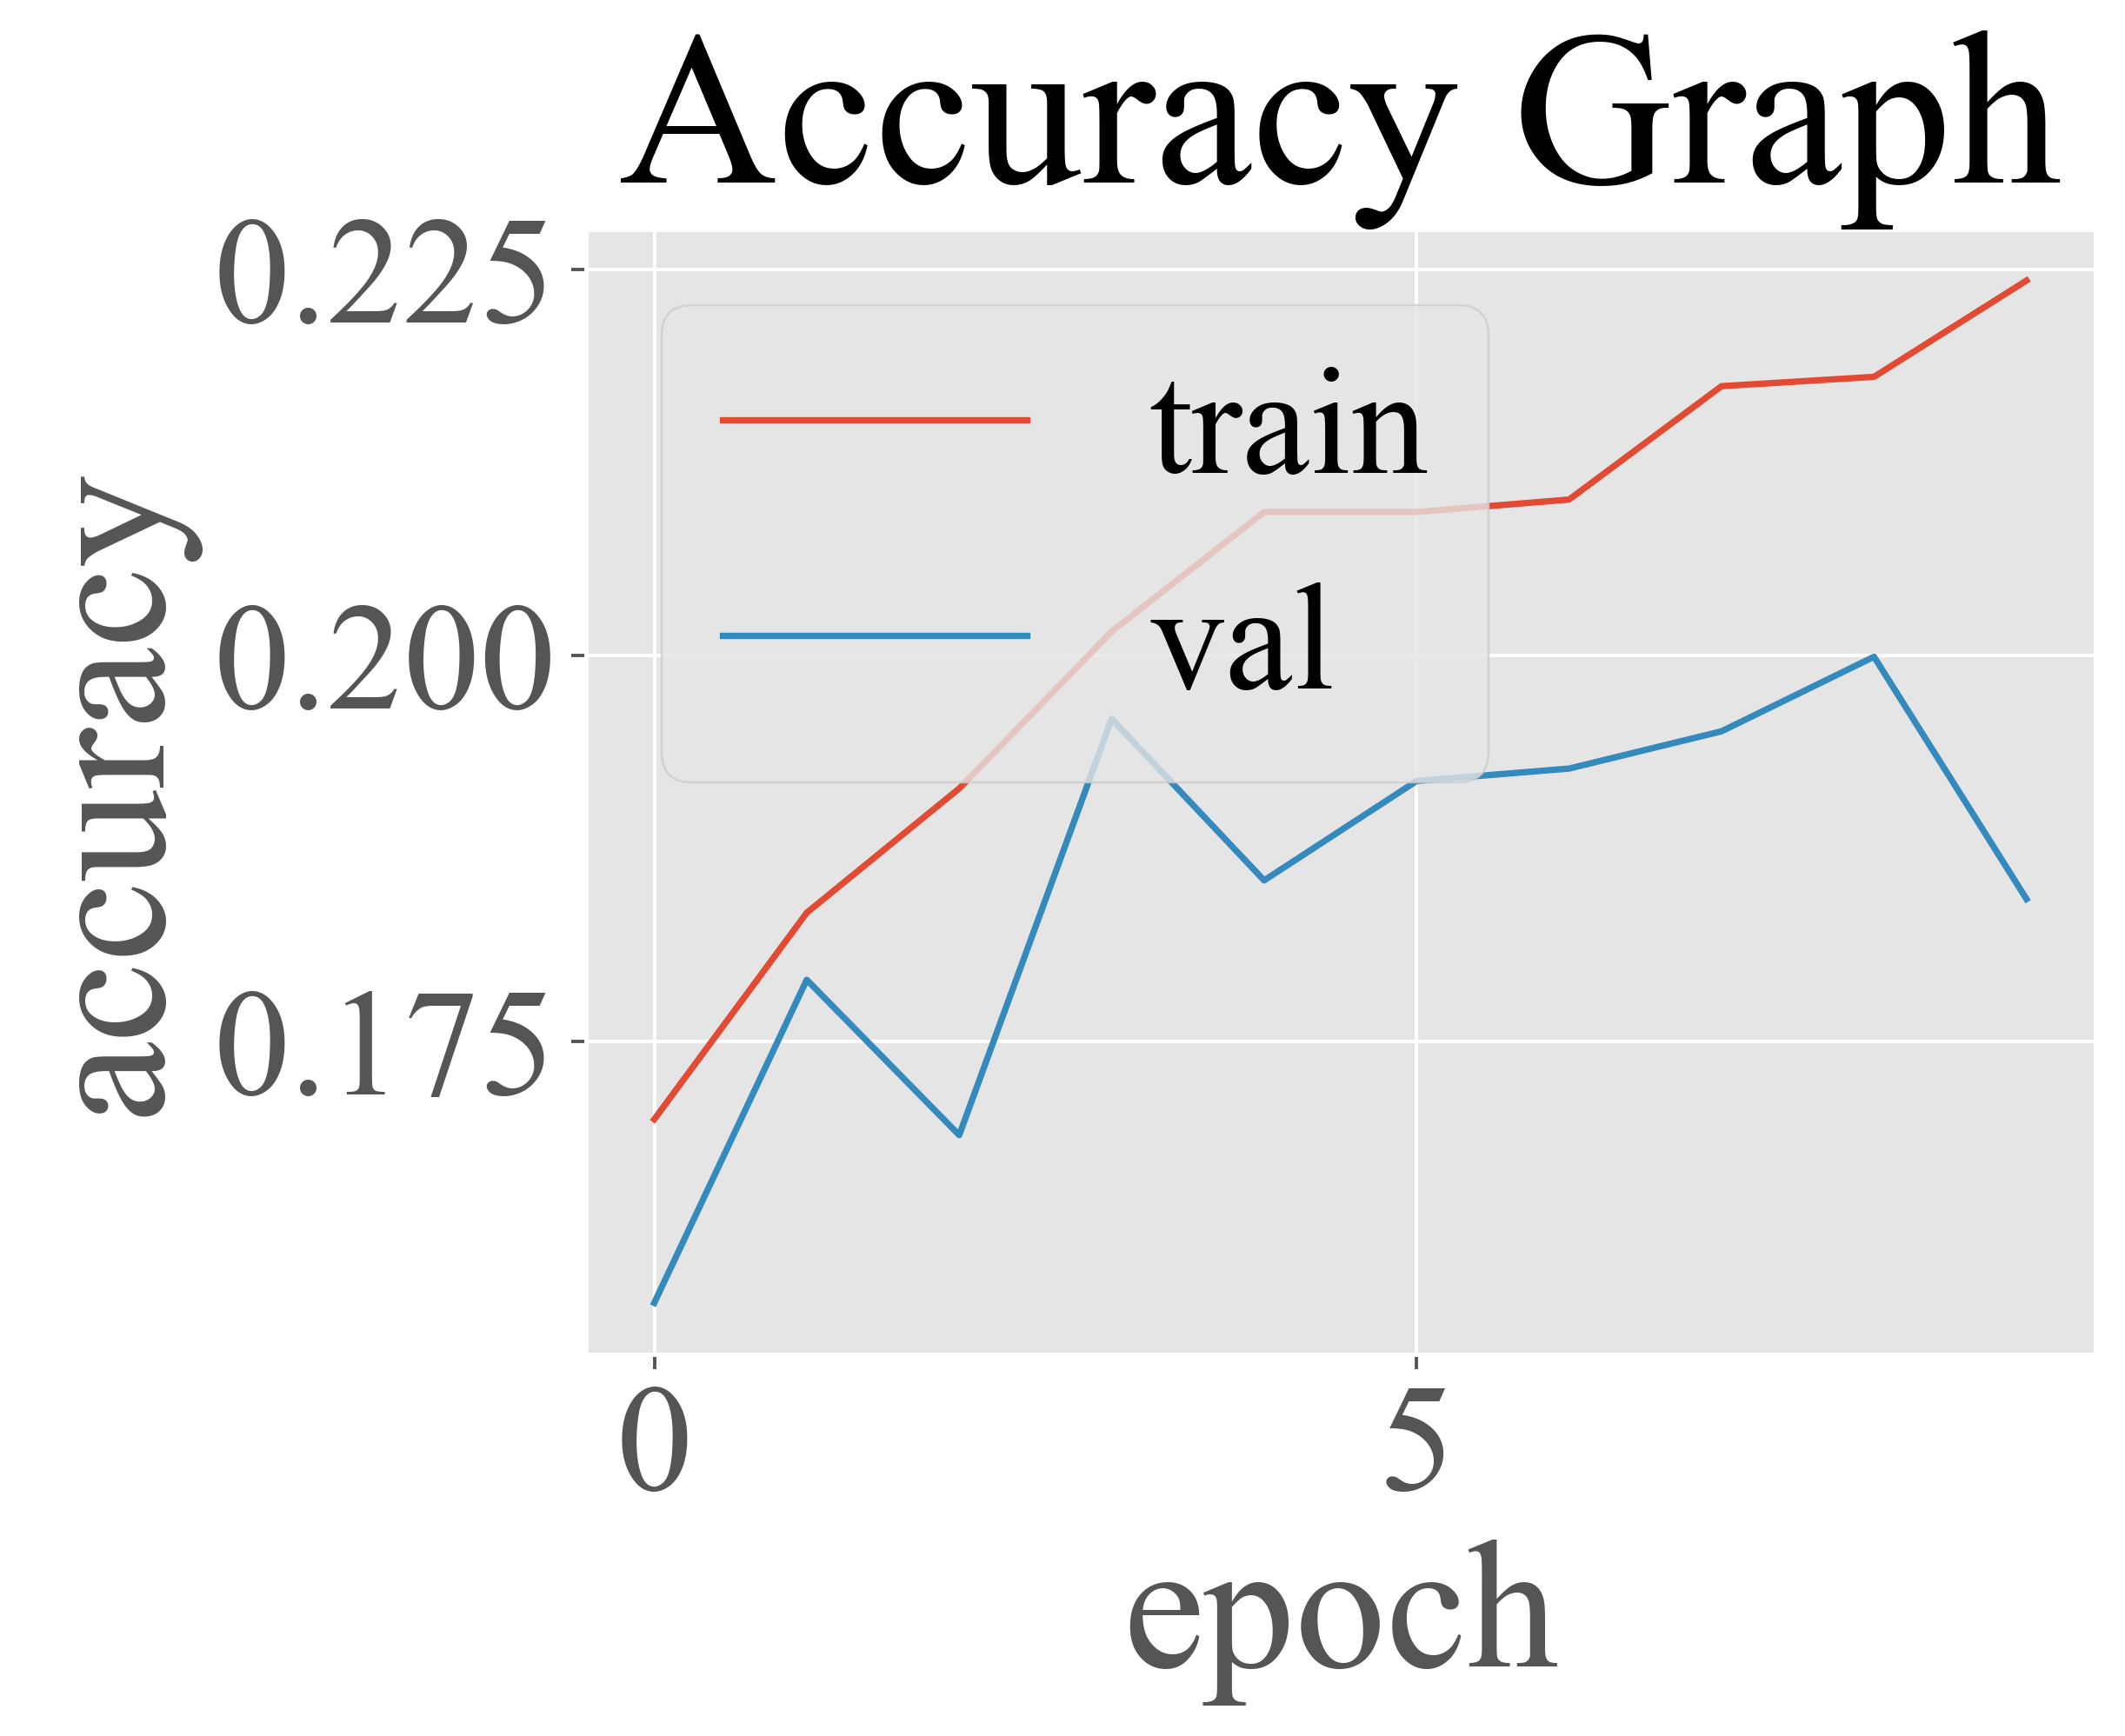

In [7]:
from models.utils import plot_line_graph

plt_data = [history.history['loss'], history.history['val_loss']]
plot_line_graph(plt_data, "Loss Graph", 'loss', 'epoch', ['train', 'val'])

plt_data = [history.history['accuracy'], history.history['val_accuracy']]
plot_line_graph(plt_data, "Accuracy Graph", 'accuracy', 'epoch', ['train', 'val'])


In [10]:
import keras
keras.backend.clear_session()